# zone by zone analysis

In [87]:
# this set up the  interactive visualisation mode for graphics.
%matplotlib notebook 
#%matplotlib inline
from operator import itemgetter
from itertools import groupby
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',7) #only visualise 7 rows when displaying tables
#from vega import vegalite
#import vega
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import feature
from skimage import measure
import cv2
from PIL import Image
from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8

<IPython.core.display.Javascript object>


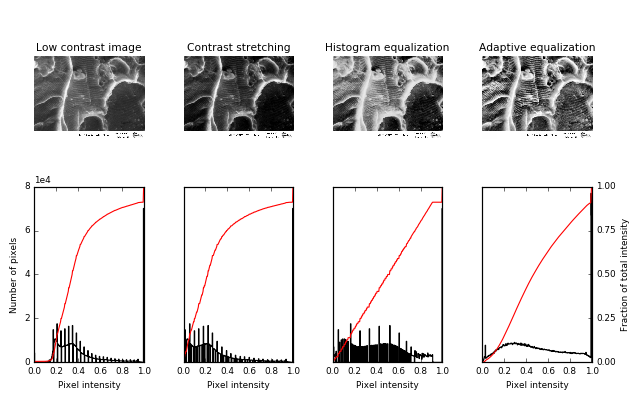

In [88]:
def plot_img_and_hist(image, axes, bins=256):

    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box-forced')

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
tiff_file = "samples/CET0127527_026.tif"

img = plt.imread(tiff_file)
img  = img[:,:,0]

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [116]:
def analyse_sigma(im):

    im  = im[:,:,0]

    im = im[0:655, 0:1024]
    img_adapteq = exposure.equalize_adapthist(im, clip_limit=0.03)
    maximum=[]
    for sigma in np.arange(0.0, 4.0, 0.1):
        edges = feature.canny(img_adapteq ,sigma)
        res=[]
        for k in range(edges.shape[1]):
            ranges = []
            j, = np.where( edges[:,k]==True)
            data=j
            for key, group in groupby(enumerate(data), lambda i: i[0] - i[1]):
                group = list(map(itemgetter(1), group))
                if len(group)>1:
                    edges[group[1]:group[-1]+1,k]=False

                ranges.append(group)## extrapolate the fisrt value to the one just after  
        ##res = np.sum(edges,axis=0)/2
        ##res = res[0:-1] ## remove the last value wich is always 0 by the algo
        ##res[0] = res[1]


            res.append(len(ranges)/(2))
        s = pd.Series(res)
        r = s.rolling(window=50,center=True,min_periods=3).mean()
        maximum.append(np.max(r))
    df = pd.DataFrame({'Max nb stries':maximum})
    
    return {'im': im, 'edges':edges,'df':df}


def window_selection(im):
    
    im  = im[:,:,0]
    im = im[0:655, 0:1024]
    img_adapteq = exposure.equalize_adapthist(im, clip_limit=0.03)
    error=[]
    edges = feature.canny(img_adapteq ,1.1)
    res=[]
    for k in range(edges.shape[1]):
        ranges = []
        j, = np.where( edges[:,k]==True)
        data=j
        for key, group in groupby(enumerate(data), lambda i: i[0] - i[1]):
            group = list(map(itemgetter(1), group))
            if len(group)>1:
                edges[group[1]:group[-1]+1,k]=False

            ranges.append(group)## extrapolate the fisrt value to the one just after  
        ##res = np.sum(edges,axis=0)/2
        ##res = res[0:-1] ## remove the last value wich is always 0 by the algo
        ##res[0] = res[1]


        res.append(len(ranges)/(2))
    s = pd.Series(res)
    for k in range(5,200,5):
        smoothedSignal = s.rolling(window=k,center=True,min_periods=3).mean()
        error.append(np.sum((smoothedSignal - s)**2))
    error=[(error[i])**0.5 for i in range(len(error))]
    return {'error': error}


In [112]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('samples/*.tif'):
    im=plt.imread(filename)
    image_list.append(im)
    
res = [ analyse_sigma(x) for x in image_list]

In [118]:
err=[window_selection(x) for x in image_list]

<IPython.core.display.Javascript object>


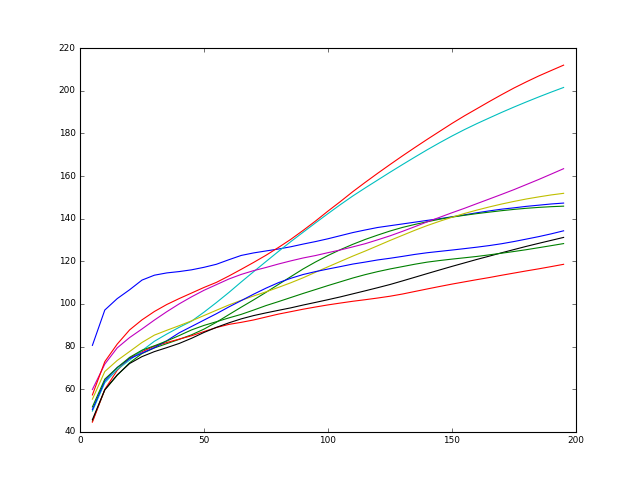

[[<matplotlib.lines.Line2D at 0x11a735f28>],

In [119]:
[plt.plot(np.arange(5,200,5),err[i]['error']) for i in range(len(err))]

<IPython.core.display.Javascript object>


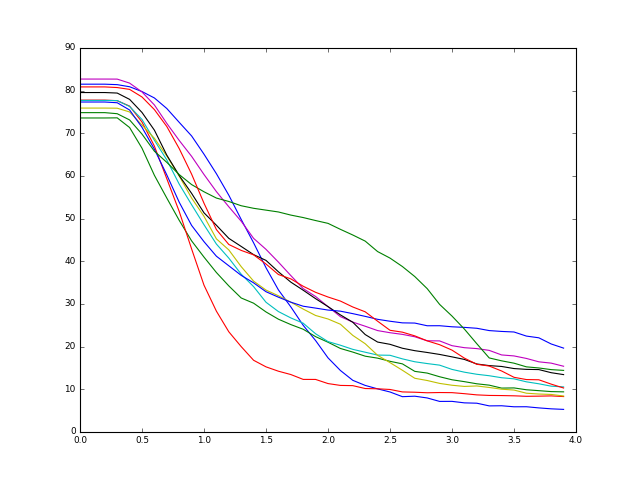

[[<matplotlib.lines.Line2D at 0x1195a27b8>],

In [115]:
[plt.plot(np.arange(0,4,0.1),res[i]['df']) for i in range(len(res))]